In [51]:
!export PYTHONPATH=&PYTHONPATH:/home/user/movie_recomender/

/bin/bash: line 1: PYTHONPATH:/home/user/movie_recomender/: No such file or directory


In [1]:
! pip install imageio


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from imageio.v3 import imread
from collections import Counter
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from data import MovieLensSequenceDataset
from movielens_transformer import (
    MovieLensTransformer,
    MovieLensTransformerConfig,
    TransformerConfig,
)
import torch.nn.functional as F
from dacite import from_dict
import pprint
from model_train import run_model_training, load_config, get_model_config
from eval import (
    get_model_predictions,
    get_popular_movies,
    get_popular_movie_predictions,
    calculate_relevance,
    calculate_metrics,
)
from sklearn.metrics import ndcg_score

## Movielens Dataset

start with reading and exploring the dataset

In [3]:
users = pd.read_csv(
    "./data/ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={
        "user_id": np.int32,
        "sex": "category",
        "age_group": "category",
        "occupation": "category",
        "zip_code": str,
    },
)

ratings = pd.read_csv(
    "./data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={
        "user_id": np.int32,
        "movie_id": np.int32,
        "rating": np.int8,
        "unix_timestamp": np.int32,
    },
)

movies = pd.read_csv(
    "./data/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={"movie_id": np.int32, "title": str, "genres": str},
)

In [4]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Tokenization

tokenize the user_ids and movie_ids such that both map on to 0:N space, where N is the number of unique entities.

In [7]:
# user ids
unique_user_ids = users["user_id"].unique()
unique_user_ids.sort()

# movie ids
unique_movie_ids = movies["movie_id"].unique()
unique_movie_ids.sort()

# tokenization
user_id_tokens = {user_id: i for i, user_id in enumerate(unique_user_ids)}
movie_id_tokens = {movie_id: i for i, movie_id in enumerate(unique_movie_ids)}

## Sequence Generation

In [8]:
ratings["user_id_tokens"] = ratings["user_id"].map(user_id_tokens)
ratings["movie_id_tokens"] = ratings["movie_id"].map(movie_id_tokens)

In [9]:
ratings_ordered = (
    ratings[["user_id_tokens", "movie_id_tokens", "unix_timestamp", "rating"]]
    .sort_values(by="unix_timestamp")
    .groupby("user_id_tokens")
    .agg(list)
    .reset_index()
)

In [10]:
ratings_ordered.head(2)

,user_id_tokens,movie_id_tokens,unix_timestamp,rating
0,0,"[3117, 1672, 1250, 1009, 2271, 1768, 3339, 118...","[978300019, 978300055, 978300055, 978300055, 9...","[4, 4, 5, 5, 3, 5, 4, 4, 5, 4, 3, 5, 4, 4, 4, ..."
1,1,"[1180, 1199, 1192, 2648, 1273, 2874, 1207, 117...","[978298124, 978298151, 978298151, 978298196, 9...","[4, 3, 4, 3, 5, 4, 5, 5, 5, 4, 4, 2, 5, 4, 4, ..."


In [11]:
sequence_length = 5
min_sequence_length = 1
window_size = 1

generate a sequence for one user_id and make sure we generate the correct sequences. Then we can expand that to all the data.

In [12]:
sample_data = ratings_ordered.iloc[0]
sample_movie_ids = torch.tensor(sample_data.movie_id_tokens, dtype=torch.int32)
sample_ratings = torch.tensor(sample_data.rating, dtype=torch.int8)
sample_movie_sequences = (
    sample_movie_ids.ravel().unfold(0, sequence_length, 1).to(torch.int32)
)
sample_rating_sequences = (
    sample_ratings.ravel().unfold(0, sequence_length, 1).to(torch.int8)
)

In [13]:
sample_movie_sequences

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


In [14]:
sample_rating_sequences

tensor([[4, 4, 5, 5, 3],
        [4, 5, 5, 3, 5],
        [5, 5, 3, 5, 4],
        [5, 3, 5, 4, 4],
        [3, 5, 4, 4, 5],
        [5, 4, 4, 5, 4],
        [4, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 5],
        [4, 4, 4, 5, 5],
        [4, 4, 5, 5, 5],
        [4, 5, 5, 5, 4],
        [5, 5, 5, 4, 5],
        [5, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 5],
        [4, 5, 4, 5, 4],
        [5, 4, 5, 4, 3],
        [4, 5, 4, 3, 5],
        [5, 4, 3, 5, 4],
        [4, 3, 5, 4, 4],
        [3, 5, 4, 4, 4],
        [5, 4, 4, 4, 3],
        [4, 4, 4, 3, 4],
        [4, 4, 3, 4, 4],
        [4, 3, 4, 4, 4],
        [3, 4, 4, 4, 4],
        [4, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 3],
        [4, 5, 3, 3, 4],
        [5, 3, 3, 4, 4],
        [3, 3, 4, 4, 4],
        [3, 4, 4, 4, 5],
        [4, 4, 4, 5, 3],
        [4, 4, 5, 3, 5],


In [15]:
def generate_sequences(row, sequence_length, window_size):
    movie_ids = torch.tensor(row.movie_id_tokens, dtype=torch.int32)
    ratings = torch.tensor(row.rating, dtype=torch.int8)
    movie_sequences = (
        movie_ids.ravel().unfold(0, sequence_length, window_size).to(torch.int32)
    )
    rating_sequences = (
        ratings.ravel().unfold(0, sequence_length, window_size).to(torch.int8)
    )
    return (movie_sequences, rating_sequences)

In [16]:
for i, row in ratings_ordered.iterrows():
    movie_sequences, rating_sequences = generate_sequences(
        row, sequence_length, window_size
    )
    print(movie_sequences)
    print(rating_sequences)
    break

tensor([[3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339],
        [1009, 2271, 1768, 3339, 1189],
        [2271, 1768, 3339, 1189, 2735],
        [1768, 3339, 1189, 2735,  257],
        [3339, 1189, 2735,  257,  711],
        [1189, 2735,  257,  711, 1176],
        [2735,  257,  711, 1176,  907],
        [ 257,  711, 1176,  907,  604],
        [ 711, 1176,  907,  604, 2623],
        [1176,  907,  604, 2623, 1892],
        [ 907,  604, 2623, 1892, 1959],
        [ 604, 2623, 1892, 1959, 3036],
        [2623, 1892, 1959, 3036,  926],
        [1892, 1959, 3036,  926, 1022],
        [1959, 3036,  926, 1022, 1893],
        [3036,  926, 1022, 1893, 1015],
        [ 926, 1022, 1893, 1015, 1949],
        [1022, 1893, 1015, 1949,  148],
        [1893, 1015, 1949,  148, 1081],
        [1015, 1949,  148, 1081,  902],
        [1949,  148, 1081,  902, 1267],
        [ 148, 1081,  902, 1267, 2728],
        [1081,  902, 1267, 2728, 1226],


convert all the scrappy code into a proper `Dataset` class. We will call this `MovieLensSequenceDataset`.

In [17]:
dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=5,
    window_size=1,
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
batch = next(iter(dataloader))
for t in batch:
    print(t)
    print(t.shape)
    print("-----------------------------------")

2025-07-10 12:54:14.331 | INFO     | data:__init__:89 - Creating MovieLensSequenceDataset with validation set: %s
2025-07-10 12:54:14.332 | INFO     | data:read_movielens_data:12 - Reading data from files
2025-07-10 12:54:16.532 | INFO     | data:_add_tokens:140 - Adding tokens to data
2025-07-10 12:54:16.589 | INFO     | data:_generate_sequences:159 - Generating sequences
2025-07-10 12:54:17.589 | INFO     | data:__init__:110 - Train data length: 883939
2025-07-10 12:54:17.589 | INFO     | data:__init__:111 - Validation data length: 98150


tensor([[3883, 3117, 1672, 1250, 1009],
        [3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339]], dtype=torch.int32)
torch.Size([4, 5])
-----------------------------------
tensor([[0, 4, 4, 5, 5],
        [4, 4, 5, 5, 3],
        [4, 5, 5, 3, 5],
        [5, 5, 3, 5, 4]], dtype=torch.int8)
torch.Size([4, 5])
-----------------------------------
tensor([0, 0, 0, 0], dtype=torch.int32)
torch.Size([4])
-----------------------------------
tensor([2271, 1768, 3339, 1189], dtype=torch.int32)
torch.Size([4])
-----------------------------------
tensor([3, 5, 4, 4], dtype=torch.int8)
torch.Size([4])
-----------------------------------


## Model Definition

 build the transformer based recommendation model 

```python
class InteractionMLP(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int):
        super(InteractionMLP, self).__init__()
        fc_layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                fc_layers.append(nn.Linear(input_size, hidden_size))
            else:
                fc_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))
            fc_layers.append(nn.ReLU())
        fc_layers.append(
            nn.Linear(
                hidden_sizes[-1] if hidden_sizes else input_size,
                output_size,
                bias=False,
            )
        )
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x: torch.Tensor):
        return self.fc_layers(x)

```

### Final Movielens RecSys Model

```python
class MovieLensTransformer(nn.Module):
    def __init__(self, config: MovieLensTransformerConfig):
        super().__init__()
        self.movie_transformer = Transformer(config.movie_transformer_config)
        self.user_embedding = nn.Embedding(
            config.num_users, config.user_embedding_dimension
        )

        self.output_layer = InteractionMLP(
            config.movie_transformer_config.embedding_dimension
            + config.user_embedding_dimension,
            config.interaction_mlp_hidden_sizes,
            config.movie_transformer_config.vocab_size,
        )

    def forward(self, movie_ids: torch.Tensor, user_ids: torch.Tensor):
        movie_embeddings = self.movie_transformer(movie_ids)
        user_embeddings = self.user_embedding(user_ids)
        embeddings = torch.cat([movie_embeddings, user_embeddings], dim=-1)
        return self.output_layer(embeddings)  # returns logits
```


## Testing

test the model that we defined to see if we can run a sample batch through it.

In [18]:
movie_ids, ratings, user_ids, output_movie_ids, output_ratings = batch

In [19]:
movie_ids

tensor([[3883, 3117, 1672, 1250, 1009],
        [3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339]], dtype=torch.int32)

In [20]:
user_ids

tensor([0, 0, 0, 0], dtype=torch.int32)

In [21]:
len(dataset.metadata.movie_id_tokens)

3885

In [22]:
config_json = {
    "movie_transformer_config": {
        "vocab_size": len(dataset.metadata.movie_id_tokens),
        "context_window_size": 5,
        "embedding_dimension": 32,
        "num_layers": 2,
        "num_heads": 2,
        "dropout_embeddings": 0.1,
        "dropout_attention": 0.1,
        "dropout_residual": 0.1,
        "layer_norm_epsilon": 1e-5,
    },
    "user_embedding_dimension": 32,
    "num_users": len(dataset.metadata.user_id_tokens),
    "interaction_mlp_hidden_sizes": [16],
}

config = from_dict(data_class=MovieLensTransformerConfig, data=config_json)
pprint.pprint(config)

MovieLensTransformerConfig(movie_transformer_config=TransformerConfig(vocab_size=3885,
                                                                      context_window_size=5,
                                                                      embedding_dimension=32,
                                                                      num_layers=2,
                                                                      num_heads=2,
                                                                      dropout_embeddings=0.1,
                                                                      dropout_attention=0.1,
                                                                      dropout_residual=0.1,
                                                                      layer_norm_epsilon=1e-05),
                           user_embedding_dimension=32,
                           num_users=6040,
                           interaction_mlp_hidden_sizes=[16])


In [23]:
model = MovieLensTransformer(config)
model

MovieLensTransformer(
  (movie_transformer): Transformer(
    (token_embedding): Embedding(3885, 32)
    (positional_embedding): Embedding(5, 32)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attention): CausalMultiHeadAttention(
          (qkv): Linear(in_features=32, out_features=96, bias=True)
          (out): Linear(in_features=32, out_features=32, bias=True)
          (residual_dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=32, out_features=128, bias=True)
          (activation): GELU(approximate='tanh')
          (fc2): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (layer_norm): LayerNorm((32,), eps=1e-05

In [24]:
logits = model(movie_ids=movie_ids, user_ids=user_ids)
logits.shape

torch.Size([4, 3885])

### Overfit one batch

In [25]:
batch

[tensor([[3883, 3117, 1672, 1250, 1009],
         [3117, 1672, 1250, 1009, 2271],
         [1672, 1250, 1009, 2271, 1768],
         [1250, 1009, 2271, 1768, 3339]], dtype=torch.int32),
 tensor([[0, 4, 4, 5, 5],
         [4, 4, 5, 5, 3],
         [4, 5, 5, 3, 5],
         [5, 5, 3, 5, 4]], dtype=torch.int8),
 tensor([0, 0, 0, 0], dtype=torch.int32),
 tensor([2271, 1768, 3339, 1189], dtype=torch.int32),
 tensor([3, 5, 4, 4], dtype=torch.int8)]

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
movie_ids, user_ids, output_movie_ids = (
    movie_ids.to(device),
    user_ids.to(device),
    output_movie_ids.to(device),
)

In [28]:
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()
    logits = model(movie_ids=movie_ids, user_ids=user_ids)
    loss = criterion(
        logits.view(-1, logits.shape[-1]), output_movie_ids.view(-1).long()
    )
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 8.432562828063965
Epoch 1000, Loss: 0.0003655957116279751
Epoch 2000, Loss: 9.696824417915195e-05
Epoch 3000, Loss: 4.076806362718344e-05
Epoch 4000, Loss: 1.7255257262149826e-05
Epoch 5000, Loss: 6.943897460587323e-06
Epoch 6000, Loss: 4.26171163780964e-06
Epoch 7000, Loss: 1.4603115232603159e-06
Epoch 8000, Loss: 7.748596999590518e-07
Epoch 9000, Loss: 5.662436137754412e-07


In [29]:
movie_ids

tensor([[3883, 3117, 1672, 1250, 1009],
        [3117, 1672, 1250, 1009, 2271],
        [1672, 1250, 1009, 2271, 1768],
        [1250, 1009, 2271, 1768, 3339]], device='cuda:0', dtype=torch.int32)

In [30]:
output_movie_ids

tensor([2271, 1768, 3339, 1189], device='cuda:0', dtype=torch.int32)

In [31]:
model.eval()
logits = model(movie_ids=movie_ids, user_ids=user_ids)
print(logits)

tensor([[ -3.1492,  -3.6396,  -6.9141,  ...,  -5.4651,  -5.6196, -16.4910],
        [ -1.9274, -10.9851, -13.5066,  ...,  -1.6212, -11.6640, -15.5053],
        [ -1.8384,  -6.1182, -18.2976,  ...,  -1.1428,  -6.5696, -15.1540],
        [ -3.3904,  -3.9717,  -6.4100,  ...,  -2.7143,  -6.7109,  -7.9646]],
       device='cuda:0', grad_fn=<MmBackward0>)


In [32]:
# model output

probabilities = F.softmax(logits, dim=-1)
print(torch.argmax(probabilities, dim=-1))
print(output_movie_ids)

tensor([2271, 1768, 3339, 1189], device='cuda:0')
tensor([2271, 1768, 3339, 1189], device='cuda:0', dtype=torch.int32)




### Train Step

```python
def train_step(
    movie_ids: torch.Tensor,
    user_ids: torch.Tensor,
    movie_targets: torch.Tensor,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
):
    movie_ids, user_ids, movie_targets = (
        movie_ids.to(device),
        user_ids.to(device),
        movie_targets.to(device),
    )
    optimizer.zero_grad()
    output = model(movie_ids, user_ids)
    loss = criterion(output.view(-1, output.size(-1)), movie_targets.view(-1).long())
    loss.backward()
    optimizer.step()
    return loss.item()

```


### Validation step

```python
def validation_step(
    movie_ids: torch.Tensor,
    user_ids: torch.Tensor,
    movie_targets: torch.Tensor,
    model: nn.Module,
    criterion: torch.nn.Module,
    device: torch.device,
):
    movie_ids, user_ids, movie_targets = (
        movie_ids.to(device),
        user_ids.to(device),
        movie_targets.to(device),
    )
    with torch.no_grad():
        output = model(movie_ids, user_ids)
        loss = criterion(
            output.view(-1, output.size(-1)), movie_targets.view(-1).long()
        )
    return loss.item()
```

Based on the full training loop, has been defined in `model_train.py`.

### Dataset

```python
def get_dataset(config) -> Dataset:
    movies_file = os.path.join(config["trainer_config"]["data_dir"], "movies.dat")
    users_file = os.path.join(config["trainer_config"]["data_dir"], "users.dat")
    ratings_file = os.path.join(config["trainer_config"]["data_dir"], "ratings.dat")

    dataset = MovieLensSequenceDataset(
        movies_file=movies_file,
        users_file=users_file,
        ratings_file=ratings_file,
        sequence_length=config["movie_transformer_config"]["context_window_size"],
        window_size=1,  # next token prediction with sliding window of 1
    )
    return dataset
```


```python

def run_model_training(config: dict):
    device = config["trainer_config"]["device"]
    if device == "cuda" and not torch.cuda.is_available():
        raise ValueError("CUDA is not available")

    dataset = get_dataset(config)
    train_dataloader = DataLoader(
        dataset, batch_size=config["trainer_config"]["batch_size"], shuffle=True
    )
    validation_dataloader = DataLoader(
        dataset, batch_size=config["trainer_config"]["batch_size"], shuffle=False
    )

    model_config = get_model_config(config, dataset)

    model = MovieLensTransformer(config=model_config)

    init_weights(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["trainer_config"]["starting_learning_rate"]
    )

    best_validation_loss = np.inf

    writer = SummaryWriter(
        log_dir=config["trainer_config"]["tensorboard_dir"], flush_secs=30
    )

    for epoch in range(config["trainer_config"]["num_epochs"]):
        model.train()
        total_loss = 0.0

        pbar = trange(len(train_dataloader))
        pbar.ncols = 150
        for i, (
            movie_ids,
            rating_ids,
            user_ids,
            movie_targets,
            rating_targets,
        ) in enumerate(train_dataloader):
            loss = train_step(
                movie_ids,
                user_ids,
                movie_targets,
                model,
                optimizer,
                criterion,
                device,
            )
            total_loss += loss
            pbar.update(1)
            pbar.set_description(
                f"[Epoch = {epoch}] Current training loss (loss = {np.round(loss, 4)})"
            )
            pbar.refresh()

        pbar.close()
        train_loss = total_loss / len(train_dataloader)
        logger.info(f"Epoch {epoch}, Loss: {np.round(train_loss, 4)}")
        writer.add_scalar("loss/train", train_loss, epoch)

        model.eval()
        total_loss = 0.0

        pbar = trange(len(validation_dataloader))
        pbar.ncols = 150
        for i, (
            movie_ids,
            rating_ids,
            user_ids,
            movie_targets,
            rating_targets,
        ) in enumerate(validation_dataloader):
            loss = validation_step(
                movie_ids,
                user_ids,
                movie_targets,
                model,
                criterion,
                device,
            )
            total_loss += loss
            pbar.update(1)
            pbar.set_description(
                f"[Epoch = {epoch}] Current validation loss (loss = {np.round(loss, 4)})"
            )
            pbar.refresh()

        pbar.close()

        validation_loss = total_loss / len(validation_dataloader)
        logger.info(f"Validation Loss: {np.round(validation_loss, 4)}")
        writer.add_scalar("loss/validation", validation_loss, epoch)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            if not os.path.exists(config["trainer_config"]["model_dir"]):
                os.makedirs(config["trainer_config"]["model_dir"])
            torch.save(
                model.state_dict(),
                os.path.join(config["trainer_config"]["model_dir"], "model.pth"),
            )
```

test this with a single epoch run!

In [33]:
config_file = "./training_config.yaml"
config = load_config(config_file)
config["trainer_config"]["num_epochs"] = 1
pprint.pprint(config)

{'interaction_mlp_hidden_sizes': [16],
 'movie_transformer_config': {'context_window_size': 5,
                              'dropout_attention': 0.1,
                              'dropout_embeddings': 0.1,
                              'dropout_residual': 0.1,
                              'embedding_dimension': 32,
                              'layer_norm_epsilon': 1e-05,
                              'num_heads': 4,
                              'num_layers': 4},
 'trainer_config': {'batch_size': 4096,
                    'data_dir': './data/ml-1m',
                    'device': 'cuda',
                    'learning_rate_decay': 0.99,
                    'model_dir': './models',
                    'num_epochs': 1,
                    'penalize_duplicates_factor': 0.1,
                    'starting_learning_rate': 0.0005,
                    'tensorboard_dir': './runs',
                    'validation_fraction': 0.15},
 'user_embedding_dimension': 32}


In [34]:
run_model_training(config)

2025-07-10 12:54:37.704 | INFO     | data:__init__:89 - Creating MovieLensSequenceDataset with validation set: %s
2025-07-10 12:54:37.705 | INFO     | data:read_movielens_data:12 - Reading data from files
2025-07-10 12:54:40.008 | INFO     | data:_add_tokens:140 - Adding tokens to data
2025-07-10 12:54:40.062 | INFO     | data:_generate_sequences:159 - Generating sequences
2025-07-10 12:54:41.181 | INFO     | data:__init__:110 - Train data length: 883592
2025-07-10 12:54:41.182 | INFO     | data:__init__:111 - Validation data length: 98497
2025-07-10 12:54:41.183 | INFO     | model_train:get_model_config:103 - Model config:
MovieLensTransformerConfig(movie_transformer_config=TransformerConfig(vocab_size=3885, context_window_size=5, embedding_dimension=32, num_layers=4, num_heads=4, dropout_embeddings=0.1, dropout_attention=0.1, dropout_residual=0.1, layer_norm_epsilon=1e-05), user_embedding_dimension=32, num_users=6040, interaction_mlp_hidden_sizes=[16]) 
2025-07-10 12:54:41.194 | INFO

run a full training run for 1000 epochs. we ran the full training run and collected the loss values for training and validation using tensorboard.  loss values:

In [35]:
from tbparse import SummaryReader

log_file = "./models/events.out.tfevents.1724703053.big.514232.0"
reader = SummaryReader(log_file)
metrics = reader.scalars
print(metrics.head().to_markdown())

|    |   step | tag        |   value |
|---:|-------:|:-----------|--------:|
|  0 |      0 | loss/train | 7.41048 |
|  1 |      1 | loss/train | 6.96151 |
|  2 |      2 | loss/train | 6.71398 |
|  3 |      3 | loss/train | 6.57032 |
|  4 |      4 | loss/train | 6.41832 |


<Axes: xlabel='step'>

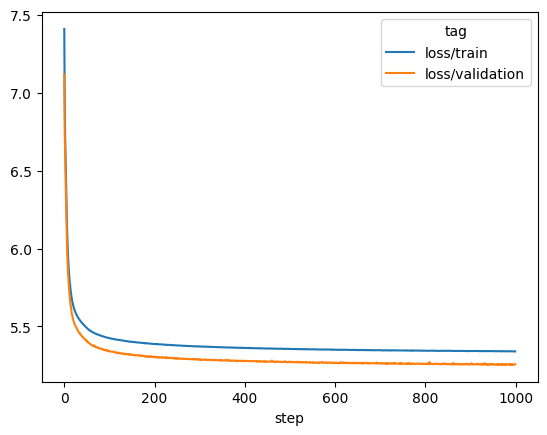

In [36]:
metrics.groupby(["step", "tag"]).mean().unstack()["value"].plot()

We can see that the model has learnt a lot already. Looking at the last few loss values, it seems that the model is still learning but it is good enough for now for our next steps.

## Model Predictions

Now we can use the trained model to do some predictions. 

In [37]:
torch.random.manual_seed(0)
test_dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=5,
    window_size=1,
)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
test_batch = next(iter(test_dataloader))

2025-07-10 12:56:13.754 | INFO     | data:__init__:89 - Creating MovieLensSequenceDataset with validation set: %s
2025-07-10 12:56:13.754 | INFO     | data:read_movielens_data:12 - Reading data from files
2025-07-10 12:56:16.257 | INFO     | data:_add_tokens:140 - Adding tokens to data
2025-07-10 12:56:16.304 | INFO     | data:_generate_sequences:159 - Generating sequences
2025-07-10 12:56:17.350 | INFO     | data:__init__:110 - Train data length: 883866
2025-07-10 12:56:17.351 | INFO     | data:__init__:111 - Validation data length: 98223


In [38]:
movie_ids, rating_ids, user_ids, movie_targets, rating_targets = test_batch

In [39]:
movies[movies["movie_id"].isin(movie_ids.numpy().ravel())]

,movie_id,title,genres
30,31,Dangerous Minds (1995),Drama
156,158,Casper (1995),Adventure|Children's
186,188,"Prophecy, The (1995)",Horror
203,205,Unstrung Heroes (1995),Comedy|Drama
225,228,Destiny Turns on the Radio (1995),Comedy
...,...,...,...
2882,2951,"Fistful of Dollars, A (1964)",Action|Western
3019,3088,Harvey (1950),Comedy
3310,3379,On the Beach (1959),Drama
3426,3495,Roadside Prophets (1992),Comedy|Drama


### Next Token Prediction

A simple way to get the topmost movie recommended is to get the token corresponding to the maximum probability. We apply softmax to the logits to get the probability and use `argmax` to get the corresponding token.

In [40]:
trained_model_state_dict = torch.load("./models/model_1000e_512_32_32_4_4.pth")
model_config = get_model_config(config, test_dataset)
trained_model = MovieLensTransformer(model_config)
trained_model.load_state_dict(trained_model_state_dict)


def predict_next_movie(model, movie_ids, user_ids):
    model.eval()
    logits = model(movie_ids=movie_ids, user_ids=user_ids)
    probabilities = F.softmax(logits, dim=-1)
    predicted_movie_ids = torch.argmax(probabilities, dim=-1)
    print(predicted_movie_ids)
    return predicted_movie_ids

/tmp/ipykernel_8800/2246622193.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_state_dict = torch.load("./models/model_1000e_512_32_32_4_4.pth")
2025-07-10

In [41]:
predicted_movie_ids = predict_next_movie(trained_model, movie_ids, user_ids)

tensor([2381, 2847,    2,   93, 2300, 3460,  588,  583,  651, 2401, 2789, 2428,
         584, 1575, 1023,  351])


Let's visualize these prediction using our movie posters:

In [42]:
merged = torch.cat([movie_ids, predicted_movie_ids.view(-1, 1)], dim=1)
merged

tensor([[1763, 2379, 2632, 1352, 1984, 2381],
        [1852, 2847, 1081,   31, 1543, 2847],
        [1050,  228,  516, 2655,  817,    2],
        [1356, 1556,  349, 2951,  372,   93],
        [1931, 1019, 2233, 1429, 2178, 2300],
        [1548,  363, 1444,  986, 2916, 3460],
        [ 188, 2872,  427, 2315, 1278,  588],
        [1854,  360, 2428,  230, 2358,  583],
        [2559, 1534, 2126, 1084, 1499,  651],
        [1085, 2401, 1942, 3379, 1932, 2401],
        [2063, 2557, 1291,  510, 2429, 2789],
        [1819, 1430,  267,  205, 1564, 2428],
        [1482, 1726, 3088, 2252, 2286,  584],
        [2269, 2038,  589, 3878, 1575, 1575],
        [ 158, 2335,  542, 2125,  453, 1023],
        [ 431, 3495, 1471, 1600, 1969,  351]])

In [43]:
rows, columns = merged.shape
movie_image_files = []

token_to_movie = {v: k for k, v in test_dataset.metadata.movie_id_tokens.items()}
for row in range(rows):
    movie_image_files.append(
        [
            f"./data/posters/{token_to_movie[image_token.item()]}.jpg"
            for image_token in merged[row]
        ]
    )

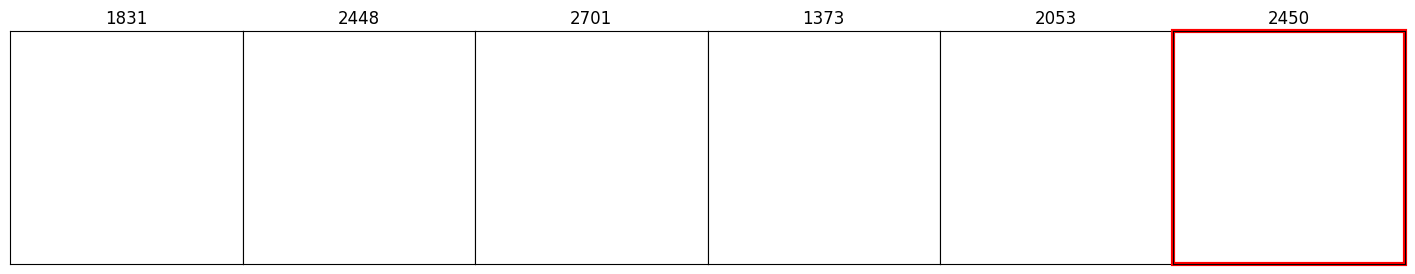

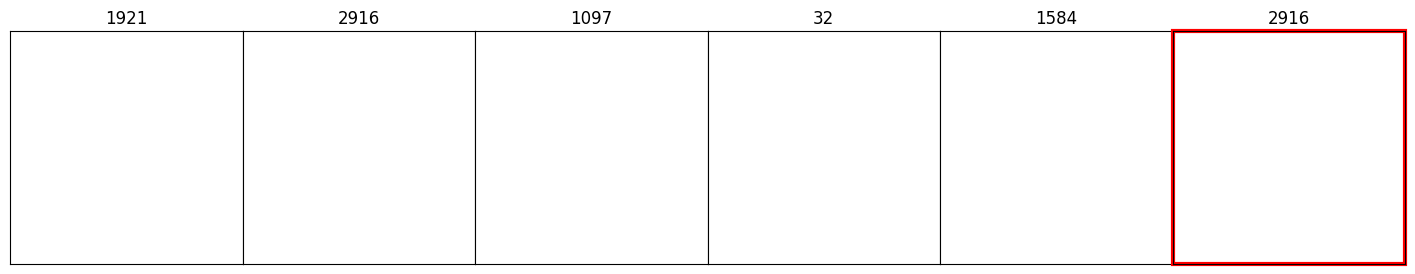

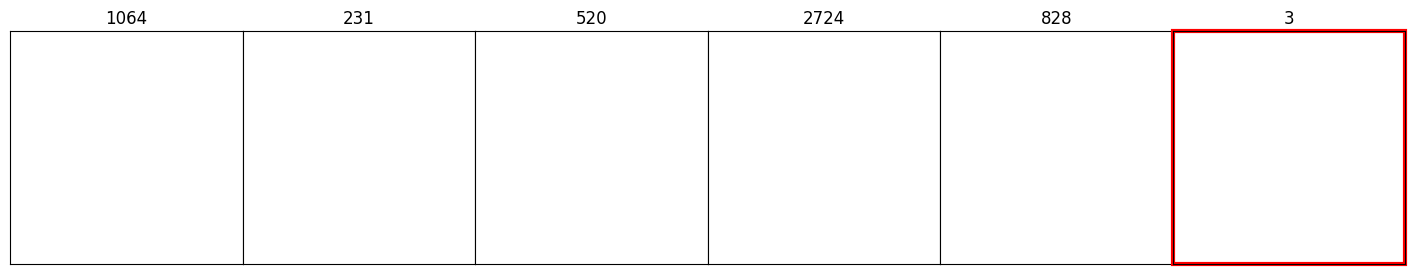

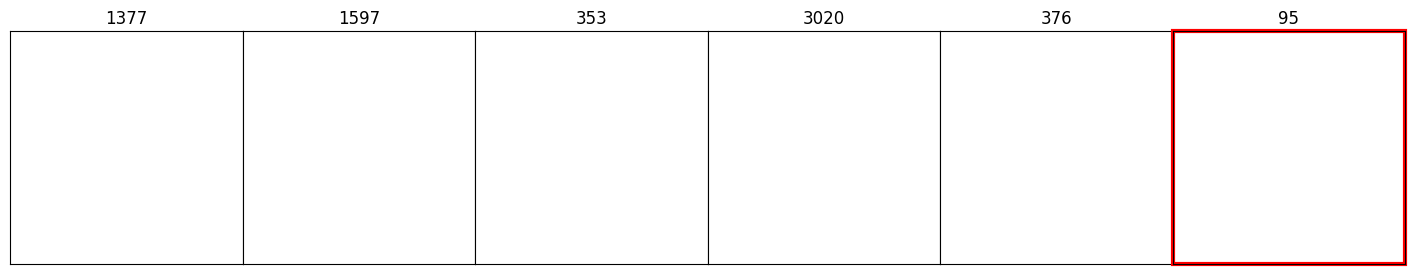

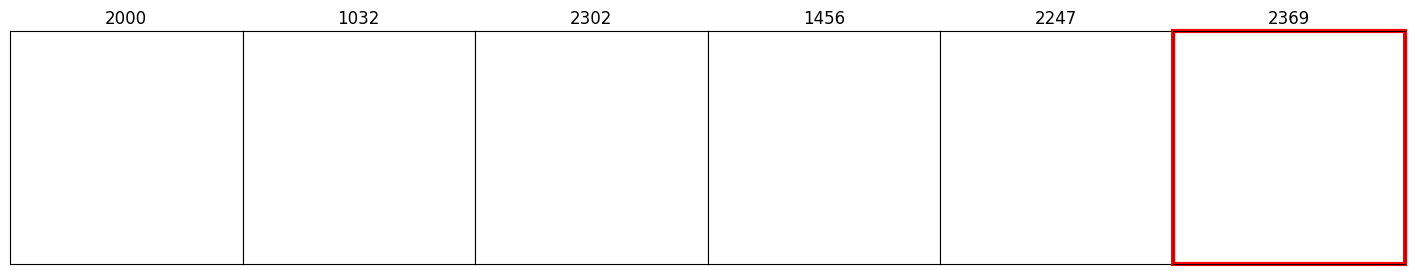

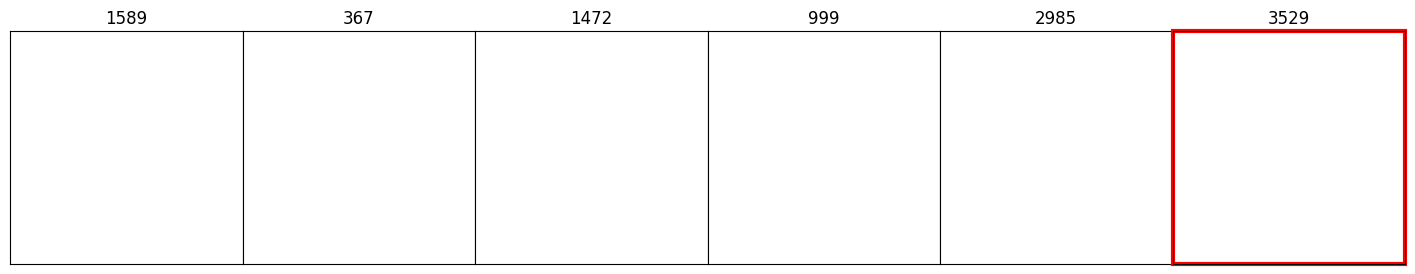

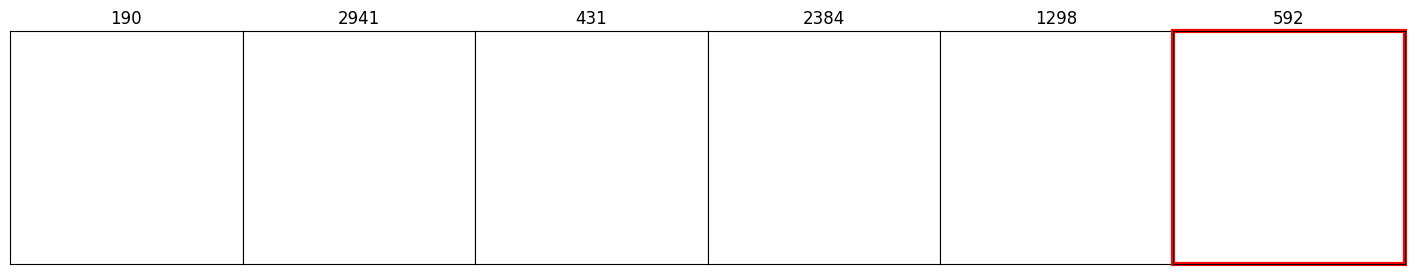

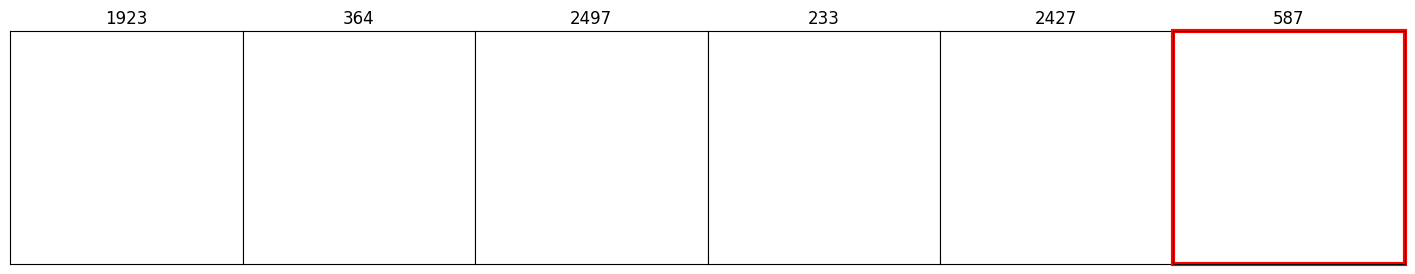

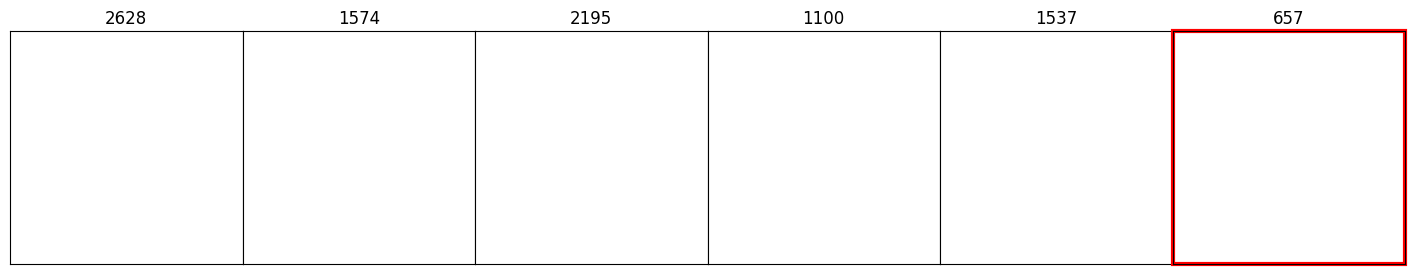

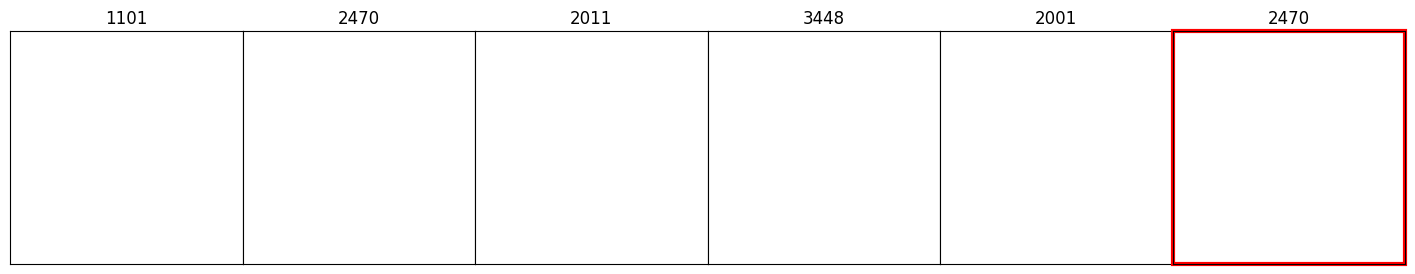

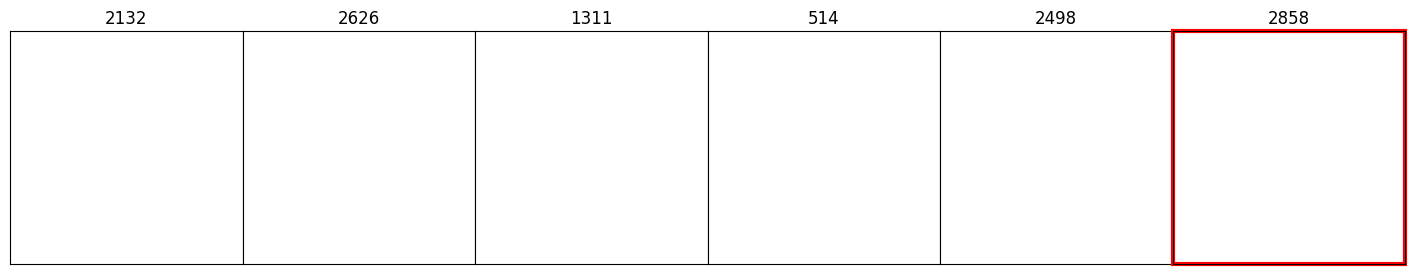

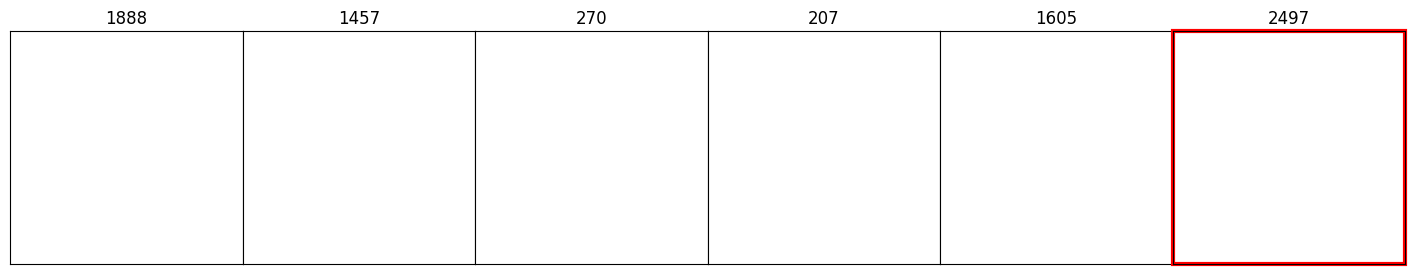

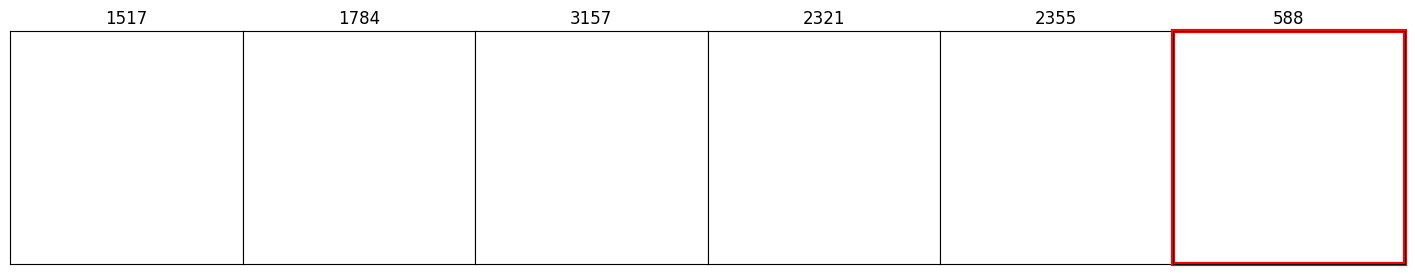

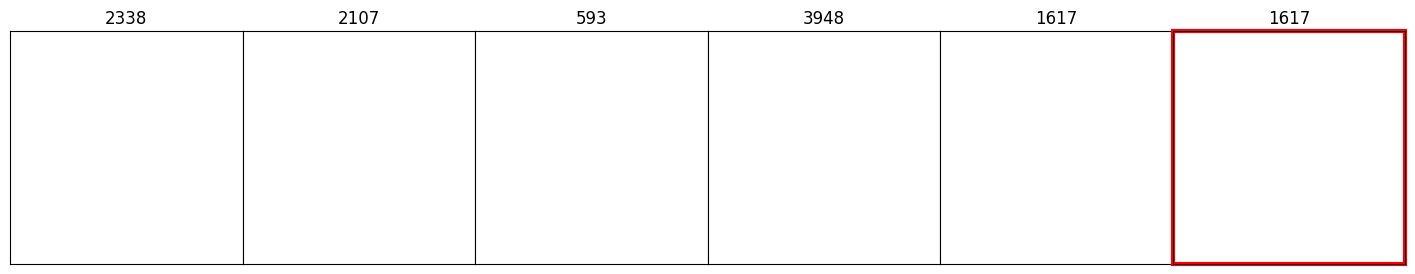

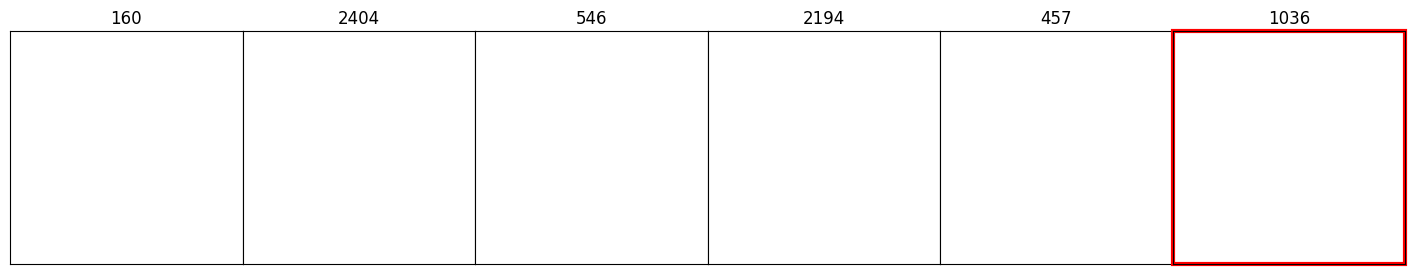

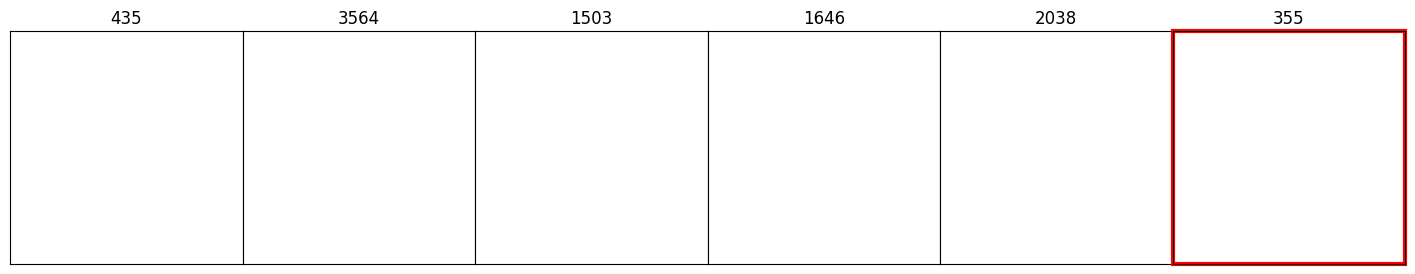

In [44]:
import os

for image_row in movie_image_files:
    fig, axs = plt.subplots(1, columns, figsize=(18, 5))
    for i, (ax, img) in enumerate(zip(axs.flat, image_row)):
        if os.path.exists(img):
            ax.imshow(imread(img))
        if i == columns - 1:
            ax.patch.set_edgecolor("red")
            ax.patch.set_linewidth(3)
        # ax.axis("off")  # Turn off axis
        ax.set_aspect("equal")
        ax.set_title(os.path.basename(img).split(".")[0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Metrics

In reality, we will recommend a few movies to the user and not just one. In addition, if we are using this model as a retreival model, we would get a few recommendations to feed it to the (re)-ranker.

Next, we will look at the quality of the model predictions. There are several different categories of metrics that we can look at.

### Prediction Quality

To assess whether the model is making accurate predictions, the common metrics that are used include:

- Precision @ K
- Recall @ K
- F-score

### Ranking Quality

To assess the quality of ranked results, common metrics include:

- MRR (Mean Reciprocal Rank)
- MAP (Mean Average Precision)
- Hit Rate @ K
- NDCG (Normalized Discounted Cumulative Gain)

### Behavioral

To further improve user experience, few metrics that go beyond just model accuracy include:

- Diversity
- Novelty
- Serendipity
- Popularity Bias


## Baseline Model

To compare our current model, we need a baseline prediction model. As a baseline, we can suggest just the most popular movies to the user i.e. show the movies with highest average ratings that the user hasn't seen. We can also add restrictions around movies that have been rated the most such that averages are statistically significant.

In [45]:
ratings = pd.read_csv(
    "./data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
    dtype={
        "user_id": np.int32,
        "movie_id": np.int32,
        "rating": np.float16,
        "unix_timestamp": np.int32,
    },
)
rating_counts = ratings["movie_id"].value_counts().reset_index()
rating_counts.columns = ["movie_id", "rating_count"]

# Get the most frequently rated movies
min_ratings_threshold = rating_counts["rating_count"].quantile(0.95)

# Filter movies based on the minimum number of ratings
popular_movies = ratings.merge(rating_counts, on="movie_id")
popular_movies = popular_movies[popular_movies["rating_count"] >= min_ratings_threshold]

# Calculate the average rating for each movie
average_ratings = popular_movies.groupby("movie_id")["rating"].mean().reset_index()

# Get the top 5 rated movies
top_5_movies = list(
    average_ratings.sort_values("rating", ascending=False).head(5).movie_id.values
)
top_5_movies

[318, 858, 50, 527, 1198]

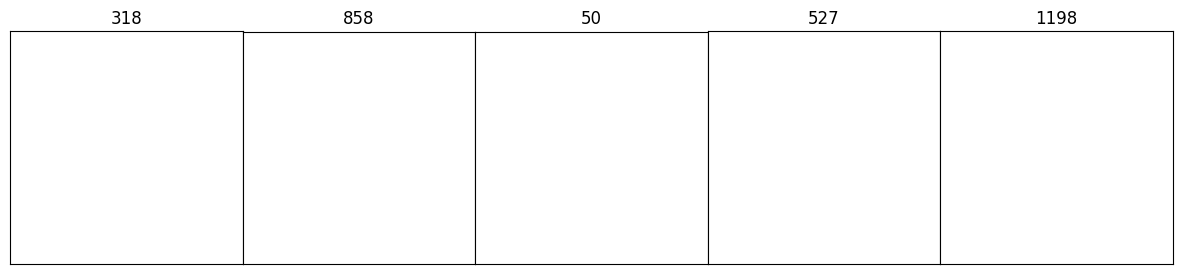

In [46]:
fig, axs = plt.subplots(1, len(top_5_movies), figsize=(15, 5))
for i, (ax, image_id) in enumerate(zip(axs.flat, top_5_movies)):
    img = f"/mnt/metaverse-nas/movielens/mlp-20m/MLP-20M/{image_id}.jpg"
    if os.path.exists(img):
        ax.imshow(imread(img))
    ax.set_aspect("equal")
    ax.set_title(os.path.basename(img).split(".")[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In the next section, we will calculate the Ranking Quality metrics to see relative performance of our transformer model vs the popular movie heuristics.

We will assume that the model will return K items (movies) based on a score for a few values of K - let's say K = 3, 5, 10. We will measure the ranking quality of these K items based on the relevant items returned.

test  code on a small batch.

In [47]:
k_values = [3, 5, 10]
batch_size = 4
sequence_length = 5
valid_dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=sequence_length,
    window_size=1,
    is_validation=True,
)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
torch.random.manual_seed(3128)
valid_batch = next(iter(valid_dataloader))
(
    movie_id_tokens,
    rating_id_tokens,
    user_id_tokens,
    output_movie_id_tokens,
    output_rating_id_tokens,
) = valid_batch
print(movie_id_tokens)
print(output_movie_id_tokens)

2025-07-10 12:56:22.491 | INFO     | data:__init__:89 - Creating MovieLensSequenceDataset with validation set: %s
2025-07-10 12:56:22.493 | INFO     | data:read_movielens_data:12 - Reading data from files
2025-07-10 12:56:25.208 | INFO     | data:_add_tokens:140 - Adding tokens to data
2025-07-10 12:56:25.259 | INFO     | data:_generate_sequences:159 - Generating sequences
2025-07-10 12:56:26.313 | INFO     | data:__init__:110 - Train data length: 883799
2025-07-10 12:56:26.313 | INFO     | data:__init__:111 - Validation data length: 98290


tensor([[1360, 2314, 2313, 3621, 1192],
        [3682, 3441, 1539,  263,  520],
        [1227, 1264,  901, 1247, 3366],
        [1353, 1178,  257, 1220, 1250]], dtype=torch.int32)
tensor([1271, 3724, 1232, 1196], dtype=torch.int32)


For getting the movie predictions from our model, we have added a new function.

```python

def get_model_predictions(
    model: nn.Module,
    movie_id_tokens: torch.Tensor,
    user_id_tokens: torch.Tensor,
    n: int,
):
    with torch.no_grad():
        # batch x num_tokens
        output = model(movie_id_tokens, user_id_tokens)

    # get top k predictions
    # we work with the top n + movie_id_tokens.shape[-1] to ensure
    # that we do not recommended the movies that the user has already seen
    _, top_tokens = output.topk(n + movie_id_tokens.shape[-1], dim=-1)

    for row in range(top_tokens.shape[0]):
        merged, counts = torch.cat((top_tokens[row], movie_id_tokens[row])).unique(
            return_counts=True
        )
        intersection = merged[torch.where(counts.gt(1))]
        top_tokens[row, :n] = top_tokens[row][
            torch.isin(top_tokens[row], intersection, invert=True)
        ][:n]
    return top_tokens[:, :n]

```

To generate the relevancy of the output, we have another function:

```python
def calculate_relevance(predictions, targets):
    return (predictions == targets.unsqueeze(1)).float()
```

In [48]:
for k in k_values:
    baseline_reciprocal_rank = torch.zeros(batch_size)
    model_reciprocal_rank = torch.zeros(batch_size)
    popular_movies_df = get_popular_movies(
        ratings_file="./data/ml-1m/ratings.dat", n=k + sequence_length
    )
    baseline_predictions = get_popular_movie_predictions(
        popular_movies_df, movie_id_tokens, n=k, batch_size=batch_size
    )
    model_predictions = get_model_predictions(
        trained_model, movie_id_tokens, user_id_tokens, n=k
    )

    baseline_relevance = calculate_relevance(
        baseline_predictions.predictions, output_movie_id_tokens
    )
    model_relevance = calculate_relevance(
        model_predictions.predictions, output_movie_id_tokens
    )

    baseline_relevant_index = torch.where(baseline_relevance == 1)
    model_relevant_index = torch.where(model_relevance == 1)

    # calculate the metrics
    baseline_reciprocal_rank[baseline_relevant_index[0]] = 1 / (
        baseline_relevant_index[1].float() + 1
    )
    model_reciprocal_rank[model_relevant_index[0]] = 1 / (
        model_relevant_index[1].float() + 1
    )
    print(f"Reciprocal Rank @ {k}: Baseline: {baseline_reciprocal_rank.mean()}")
    print(f"Reciprocal Rank @ {k}: Model: {model_reciprocal_rank.mean()}")

    # Calculate the mean average precision
    # since there could only be one relevant item in the predictions
    # precision = relevance_for_row.sum() / k
    baseline_map = baseline_relevance.sum(dim=1) / k
    model_map = model_relevance.sum(dim=1) / k

    print(f"Mean Average Precision @ {k}: Baseline: {baseline_map.mean()}")
    print(f"Mean Average Precision @ {k}: Model: {model_map.mean()}")

    # Calculate the NDCG
    baseline_ndcg = ndcg_score(baseline_relevance, baseline_predictions.scores, k=k)
    model_ndcg = ndcg_score(model_relevance, model_predictions.scores, k=k)

    print(f"NDCG @ {k}: Baseline: {baseline_ndcg}")
    print(f"NDCG @ {k}: Model: {model_ndcg}")

    print("---------------------------------------------------")

Reciprocal Rank @ 3: Baseline: 0.0
Reciprocal Rank @ 3: Model: 0.125
Mean Average Precision @ 3: Baseline: 0.0
Mean Average Precision @ 3: Model: 0.0833333358168602
NDCG @ 3: Baseline: 0.0
NDCG @ 3: Model: 0.15773243839286433
---------------------------------------------------
Reciprocal Rank @ 5: Baseline: 0.0
Reciprocal Rank @ 5: Model: 0.125
Mean Average Precision @ 5: Baseline: 0.0
Mean Average Precision @ 5: Model: 0.05000000074505806
NDCG @ 5: Baseline: 0.0
NDCG @ 5: Model: 0.15773243839286433
---------------------------------------------------
Reciprocal Rank @ 10: Baseline: 0.0
Reciprocal Rank @ 10: Model: 0.1840277761220932
Mean Average Precision @ 10: Baseline: 0.0
Mean Average Precision @ 10: Model: 0.07500000298023224
NDCG @ 10: Baseline: 0.0
NDCG @ 10: Model: 0.31185615650529175
---------------------------------------------------


 add a function for this and generate for the full validation set

In [49]:
batch_size = 512
sequence_length = 5
valid_dataset = MovieLensSequenceDataset(
    movies_file="./data/ml-1m/movies.dat",
    users_file="./data/ml-1m/users.dat",
    ratings_file="./data/ml-1m/ratings.dat",
    sequence_length=sequence_length,
    window_size=1,
    is_validation=True,
)
# shuffle doesnt matter for calculating metrics
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


metrics = {}

for k in k_values:
    # we would torch.cat these later
    baseline_relevances = []
    model_relevances = []
    baseline_scores = []
    model_scores = []

    popular_movies_df = get_popular_movies(
        ratings_file="./data/ml-1m/ratings.dat", n=k + sequence_length
    )
    for batch in valid_dataloader:
        (
            movie_id_tokens,
            rating_id_tokens,
            user_id_tokens,
            output_movie_id_tokens,
            output_rating_id_tokens,
        ) = batch
        baseline_predictions = get_popular_movie_predictions(
            popular_movies_df, movie_id_tokens, n=k, batch_size=movie_id_tokens.shape[0]
        )
        model_predictions = get_model_predictions(
            trained_model, movie_id_tokens, user_id_tokens, n=k
        )
        baseline_relevance = calculate_relevance(
            baseline_predictions.predictions, output_movie_id_tokens
        )
        model_relevance = calculate_relevance(
            model_predictions.predictions, output_movie_id_tokens
        )
        baseline_relevances.append(baseline_relevance)
        model_relevances.append(model_relevance)
        baseline_scores.append(baseline_predictions.scores)
        model_scores.append(model_predictions.scores)

    baseline_relevances_tensor = torch.cat(baseline_relevances)
    model_relevances_tensor = torch.cat(model_relevances)
    baseline_scores_tensor = torch.cat(baseline_scores)
    model_scores_tensor = torch.cat(model_scores)

    # Calculate the metrics
    baseline_metrics = calculate_metrics(
        baseline_relevances_tensor, baseline_scores_tensor
    )
    model_metrics = calculate_metrics(model_relevances_tensor, model_scores_tensor)

    metrics[k] = (baseline_metrics, model_metrics)

    print(f"[Baseline] Reciprocal Rank @ {k}:        {baseline_metrics.MRR}")
    print(f"[Model]    Reciprocal Rank @ {k}:        {model_metrics.MRR}")
    print(f"[Baseline] Mean Average Precision @ {k}: {baseline_metrics.MAP}")
    print(f"[Model]    Mean Average Precision @ {k}: {model_metrics.MAP}")
    print(f"[Baseline] NDCG @ {k}:                   {baseline_metrics.NDCG}")
    print(f"[Model]    NDCG @ {k}:                   {model_metrics.NDCG}")
    print("---------------------------------------------------")

2025-07-10 12:56:34.283 | INFO     | data:__init__:89 - Creating MovieLensSequenceDataset with validation set: %s
2025-07-10 12:56:34.284 | INFO     | data:read_movielens_data:12 - Reading data from files
2025-07-10 12:56:36.826 | INFO     | data:_add_tokens:140 - Adding tokens to data
2025-07-10 12:56:36.881 | INFO     | data:_generate_sequences:159 - Generating sequences
2025-07-10 12:56:38.118 | INFO     | data:__init__:110 - Train data length: 884128
2025-07-10 12:56:38.119 | INFO     | data:__init__:111 - Validation data length: 97961


[Baseline] Reciprocal Rank @ 3:        0.00014801809447817504
[Model]    Reciprocal Rank @ 3:        0.07903826236724854
[Baseline] Mean Average Precision @ 3: 0.0001837465970311314
[Model]    Mean Average Precision @ 3: 0.12025193870067596
[Baseline] NDCG @ 3:                   0.00015737393733220568
[Model]    NDCG @ 3:                   0.0895683077691279
---------------------------------------------------
[Baseline] Reciprocal Rank @ 5:        0.00025316199753433466
[Model]    Reciprocal Rank @ 5:        0.09153863787651062
[Baseline] Mean Average Precision @ 5: 0.0006226967670954764
[Model]    Mean Average Precision @ 5: 0.1755494475364685
[Baseline] NDCG @ 5:                   0.0003423932637948411
[Model]    NDCG @ 5:                   0.11222320211899761
---------------------------------------------------
[Baseline] Reciprocal Rank @ 10:        0.0005179134896025062
[Model]    Reciprocal Rank @ 10:        0.10491031408309937
[Baseline] Mean Average Precision @ 10: 0.00278682331

In [50]:
metrics_df = pd.DataFrame(
    [
        {
            "k": k,
            "baseline_mrr": v[0].MRR,
            "model_mrr": v[1].MRR,
            "baseline_map": v[0].MAP,
            "model_map": v[1].MAP,
            "baseline_ndcg": v[0].NDCG,
            "model_ndcg": v[1].NDCG,
        }
        for k, v in metrics.items()
    ]
)
metrics_df

,k,baseline_mrr,model_mrr,baseline_map,model_map,baseline_ndcg,model_ndcg
0,3,0.000148,0.079038,0.000184,0.120252,0.000157,0.089568
1,5,0.000253,0.091539,0.000623,0.175549,0.000342,0.112223
2,10,0.000518,0.104910,0.002787,0.277059,0.001019,0.144873


From the results, we can see that our model is way way better than just suggesting the top k movies by ratings. 